In [1]:
from functools import lru_cache
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedKFold
sns.set()

from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import DBSCAN


In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion

In [3]:
df_, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df_)

# Introducción
https://scikit-learn.org/stable/modules/naive_bayes.html

Laburaremos con el modelo de **Naive Bayes**, se conocen 3 diferentes formas de implementar: 
* Cuando trabajamos con features continuos -> (GaussianNB)
* Cuando trabajamos con features discretos -> (MultinomialNB)
* Cuando trabajamos con features categoricos -> (CategoricalNB)

Estaremos utilizando los 3 tipos de tecnicas de Naive Bayes. Esto implica tener que dividir nuestro dataset.

# GaussianNB

Solo para valores continuos. Es decir nos quedaremos con las 4 columnas numéricas continuas siguientes:

In [4]:
X_df.describe()

,anios_estudiados,edad,suma_declarada_bolsa_argentina,horas_trabajo_registradas
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456
std,2.664488,13.640433,7408.986951,12.347429
min,1.000000,17.000000,-4356.000000,1.000000
25%,13.000000,28.000000,0.000000,40.000000
50%,14.000000,37.000000,0.000000,40.000000
75%,16.000000,48.000000,0.000000,45.000000
max,20.000000,90.000000,99999.000000,99.000000


In [5]:
def obtener_features_continuas(df: pd.DataFrame):
    return obtener_features_continuas_personalizada(df, ['edad', 'anios_estudiados', 'suma_declarada_bolsa_argentina', 'horas_trabajo_registradas'])

def obtener_features_continuas_personalizada(df: pd.DataFrame, features_a_considerar):
    return df[features_a_considerar]

def get_dataframe_scaled(df, scaler_r):
    scaled = scaler_r.fit_transform(df)
    return pd.DataFrame(scaled, index = df.index, columns = df.columns)

def get_dataframe_polynomial(df, grade_r, interaction_only_r):
    poly = PolynomialFeatures(grade_r, interaction_only = interaction_only_r)
    return pd.DataFrame(poly.fit_transform(df))  

def get_dataframe_scaler_polynomial(df, scaler_rr, grade_rr, interaction_only_rr):
    df_scaled = get_dataframe_scaled(df, scaler_r = scaler_rr)
    df_scaled_poly = get_dataframe_polynomial(df_scaled, grade_r = grade_rr, interaction_only_r = interaction_only_rr)
    return df_scaled_poly


def get_dataframe_polynomial_scaler(df, scaler_rr, grade_rr, interaction_only_rr):
    df_poly = get_dataframe_polynomial(df, grade_r = grade_rr, interaction_only_r = interaction_only_rr)
    df_scaled_poly = get_dataframe_scaled(df_poly, scaler_r = scaler_rr)
    return df_scaled_poly


## Primer preprocessing simple

Fitting 10 folds for each of 7 candidates, totalling 70 fits
AUC-ROC score sobre test:  0.8340617326303625
AUC-ROC score sobre train:  0.8368621485575307
Accuracy sobre test:  0.7971748810072163
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-08}
              precision    recall  f1-score   support

  Bajo valor       0.98      0.80      0.88      6042
  Alto valor       0.23      0.76      0.35       471

    accuracy                           0.80      6513
   macro avg       0.60      0.78      0.62      6513
weighted avg       0.92      0.80      0.84      6513



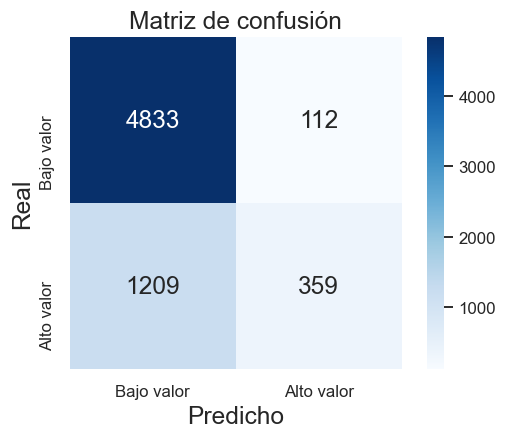

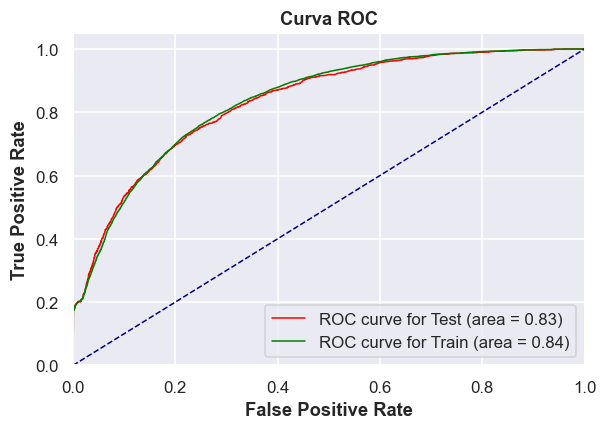

In [6]:
X_df_c = obtener_features_continuas(X_df) 
X_train, X_test, y_train, y_test = train_test_split(X_df_c, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Guardamos la prediccion de probabilidad de cada clase para usarlo en un futuro ensamble. Por ahora nos quedamos como mejor preprocesamiento a éste ultimo aplicado.

In [7]:
proba_gauss_train = clf.predict_proba(X_train)
proba_gauss_test = clf.predict_proba(X_test)

## Consideremos 'anios_estudiados' como discreta, es decir: no-continua.

In [8]:
X_df_c = obtener_features_continuas_personalizada(X_df, ['edad', 'suma_declarada_bolsa_argentina', 'horas_trabajo_registradas']) 
X_train, X_test, y_train, y_test = train_test_split(X_df_c, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))


Fitting 10 folds for each of 7 candidates, totalling 70 fits
AUC-ROC score sobre test:  0.7933111806401024
AUC-ROC score sobre train:  0.7956611391948678


Vemos que el resultado no es bueno, por ende consideramos tambien como continua a la de anios estuadiados aunque podria no serlo.

## Segundo preprocessing: Scaler -> PolynomialFeatures(2,interaction_only = True)

Probaremos diferentes variantes para los preprocesings combinados de Scalers+PolynomialFeatures.

Para esto, crearemos esta funcion que usaremos a lo largo del notebook en los diferentes metodos de Naive Bayes.

Especialmente lo que realiza es, en un for, aplicar 5 diferentes 'scalers' y un PolynomialFeatures con un grado especifico (e 'intercation_only' del PolynomialFeatures) y luego se entrena y predice segun la métrica solicitada (AUC-ROC) ademas de mostrarnos el mejor hiperparametro usado en el modelo.

Seria como trabajar 5 preprocesamietos. Ademas lo haremos de 2 formas: 
* Primero aplicamos un Scaler y luego un PolynomialFeatures
* Segundo aplicamos un PolynomialFeatures y luego un Scaler 

Es decir, totalizando 10 preprocesamientos.

A esta funcion se le puede pasar el clasificador (GaussianNB, MultinomialNB o CategorialNB), como el dataset de entrenameinto y validacion, ademas el grado/intercation_only del PolynomialFeatures y tambien los hiperparametros a probar con GridSearch sobre el clasificador recibido.


In [9]:
def auc_roc_scaler_polynomial(clf_r, XX_df, yy_df, grade, interaction_only, params):
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), Normalizer()]

    for count, scaler in enumerate(scalers):
        df_scaled_poly = get_dataframe_scaler_polynomial(XX_df, scaler, grade, interaction_only)
        df_poly_scaled = get_dataframe_polynomial_scaler(XX_df, scaler, grade, interaction_only)
        dfs = {'scaled -> poly': df_scaled_poly, 'poly -> scaled': df_poly_scaled}
        for name, df_received in dfs.items(): 
            print("---------------------------------------------------------------------")
            print("Para dataset: ", name)
            print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
            X_train, X_test, y_train, y_test = train_test_split(df_received, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
                
            cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
            clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
                
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
            print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
            print("Los mejores hiperpametros elegidos: ", clf.best_params_)
            '''
            print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
            print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
            graficar_matriz_confusion(y_test, y_pred)
            plot_roc_curves(clf, X_test, y_test, X_train, y_train)
            '''



In [10]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_scaler_polynomial(GaussianNB(), X_df_c, y_df, 2, True, params)

---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8264946941870783
AUC-ROC score sobre train:  0.8301002450048297
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------------------------
Para dataset:  poly -> scaled
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8276267900992551
AUC-ROC score sobre train:  0.8296160234005107
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8205407441035060
AUC-ROC score sobre train:  0.8234186406413778
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------

## Tercer preprocessing: Scaler -> PolynomialFeatures(2,interaction_only = False)

In [11]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_scaler_polynomial(GaussianNB(), X_df_c, y_df, 2, False, params)

---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8242325013928726
AUC-ROC score sobre train:  0.8264795504502973
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------------------------
Para dataset:  poly -> scaled
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8295066522564536
AUC-ROC score sobre train:  0.8325269314863150
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8240017746228927
AUC-ROC score sobre train:  0.8283904027111960
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------

## Cuarto preprocessing: Scaler -> PolynomialFeatures(3, interaction_only = True)

In [12]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_scaler_polynomial(GaussianNB(), X_df_c, y_df, 3, True, params)

---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8248129939539011
AUC-ROC score sobre train:  0.8284096451732719
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------------------------
Para dataset:  poly -> scaled
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8244823156765235
AUC-ROC score sobre train:  0.8264951451477778
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8105377906976744
AUC-ROC score sobre train:  0.8144119793395450
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------

## Quinto preprocessing: Scaler -> PolynomialFeatures(3, interaction_only = False)

In [13]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_scaler_polynomial(GaussianNB(), X_df_c, y_df, 3, False, params)

---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8116925852747570
AUC-ROC score sobre train:  0.8125168185124254
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------------------------
Para dataset:  poly -> scaled
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8251647587750977
AUC-ROC score sobre train:  0.8287409186280456
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8087854795608840
AUC-ROC score sobre train:  0.8143607776227981
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------

## Sexto preprocessing: solo Polynomial

Acá solamente creamos una funcion que haga lo mismo que la anterior pero realizando solo el preproceasmietno de PolynomialFeatures

In [14]:
    def auc_roc_polynomial(clf_r, XX_df, yy_df, grade, interaction_only, params):
        
        df_poly = get_dataframe_polynomial(XX_df, grade, interaction_only)
        X_train, X_test, y_train, y_test = train_test_split(df_poly, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        
        cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
        clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        '''print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
        print("Los mejores hiperpametros elegidos: ", clf.best_params_)
        print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
        graficar_matriz_confusion(y_test, y_pred)
        plot_roc_curves(clf, X_test, y_test, X_train, y_train)'''

### Grado 2, interaction_only = True

In [15]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial(GaussianNB(), X_df_c, y_df, 2, True, params)


 AUC-ROC score sobre test:  0.8275947411320443
AUC-ROC score sobre train:  0.8295168727250595


### Grado 2, interaction_only = False

In [16]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial(GaussianNB(), X_df_c, y_df, 2, False, params)

 AUC-ROC score sobre test:  0.8074701177235303
AUC-ROC score sobre train:  0.8110934567366050


### Grado 3, interaction_only = False

In [17]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial(GaussianNB(), X_df_c, y_df, 3, False, params)

 AUC-ROC score sobre test:  0.7724691633478468
AUC-ROC score sobre train:  0.7759639479937597


### Grado 3, interaction_only = True

In [18]:
X_df_c = obtener_features_continuas(X_df) 
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial(GaussianNB(), X_df_c, y_df, 3, True, params)

 AUC-ROC score sobre test:  0.8179120194589464
AUC-ROC score sobre train:  0.8201623476932323


## Septimo preprocessing: solo Scalers

De forma similar a la anterior función, lo haremos solo con los 5 escalados, sin aplicar un PolynomialFeatures. Definamos función:

In [19]:
def auc_scaler(clf_r, XX_df, yy_df, params):
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), Normalizer()]
    for count, scaler in enumerate(scalers):
        print("---------------------------------------------------------------------")
        print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
        df_scaled = get_dataframe_scaled(XX_df, scaler)
        X_train, X_test, y_train, y_test = train_test_split(df_scaled, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        
        cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
        clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        print("Los mejores hiperpametros elegidos: ", clf.best_params_)
        '''
        print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
        graficar_matriz_confusion(y_test, y_pred)
        print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
        plot_roc_curves(clf, X_test, y_test, X_train, y_train)'''

  

In [20]:
X_df_c = obtener_features_continuas(X_df) 
params =  {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_scaler(GaussianNB(), X_df_c, y_df, params)

---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
 AUC-ROC score sobre test:  0.8337024230824788
AUC-ROC score sobre train:  0.8367178099385664
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.8337020361734178
AUC-ROC score sobre train:  0.8367175963125736
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con scaler de RobustScaler()
 AUC-ROC score sobre test:  0.8337024230824788
AUC-ROC score sobre train:  0.8367176688647975
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con scaler de PowerTransformer()
 AUC-R

# MultinomialNB

Solo para valores discretos.

Unica variable discreta a considerar podria es la de 'anios_estudiados' aunque la habiamos considerado continua, pero si no haciamos eso GaussianNB nos daba muy mal. 

Ademas como variables discretas consideraremos convertir con OneHotEncodning y OrdinalEncoder a las categoricas. 


Ademas tal como hicimos en el TP1, agrupamos la edad por rangos.

In [21]:
X_df.describe()

,anios_estudiados,edad,suma_declarada_bolsa_argentina,horas_trabajo_registradas
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456
std,2.664488,13.640433,7408.986951,12.347429
min,1.000000,17.000000,-4356.000000,1.000000
25%,13.000000,28.000000,0.000000,40.000000
50%,14.000000,37.000000,0.000000,40.000000
75%,16.000000,48.000000,0.000000,45.000000
max,20.000000,90.000000,99999.000000,99.000000


In [22]:
def conversion_numerica(X_train: pd.DataFrame):
    X_train = pd.get_dummies(X_train, drop_first=True, columns=[
        'genero', 
        'estado_marital', 
        'trabajo', 
        'categoria_de_trabajo',
        'religion', 
        'rol_familiar_registrado',
        ])

    # La que tiene noción de orden la hago de 0,1,..,6        
    X = [['Jardin', 
        'Primaria - [1,6] grado', 
        'Primaria - (6,9] grado',
        'Secundario - [1,3] anio', 
        'Secundario - (3,6] anio', 
        'Universitario - [1,3] anio',
        'Universitario - (3,6] anio']]
    enc = OrdinalEncoder(categories = X)
    X_train['educacion_alcanzada'] = enc.fit_transform(X_train.loc[:,['educacion_alcanzada']])
    X_train = X_train.astype({"educacion_alcanzada": np.ubyte})

    # ¡Para ver la inversa!
    #enc.inverse_transform(X_train[['educacion_alcanzada']])

    return X_train

def obtener_features_discretas(df: pd.DataFrame):
    df_d = df[[
        'edad',
        'anios_estudiados',
        'categoria_de_trabajo',
        'educacion_alcanzada', 
        'estado_marital', 
        'genero','religion', 
        'rol_familiar_registrado', 
        'suma_declarada_bolsa_argentina',
        'horas_trabajo_registradas',
        'trabajo']].copy()
    df_d['edad'] = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy = "kmeans").fit_transform(df_d.loc[:,['edad']])
    df_d['suma_declarada_bolsa_argentina'] = KBinsDiscretizer(n_bins=8, encode='ordinal',strategy = "kmeans").fit_transform(df_d.loc[:,['suma_declarada_bolsa_argentina']])
    df_d['horas_trabajo_registradas'] = KBinsDiscretizer(n_bins=6, encode='ordinal',strategy = "kmeans").fit_transform(df_d.loc[:,['horas_trabajo_registradas']])

    df_d_n = conversion_numerica(df_d)
    return df_d_n

## Primer preprocesamiento simple

Fitting 10 folds for each of 8 candidates, totalling 80 fits
AUC-ROC score sobre test:  0.8650272255009184
AUC-ROC score sobre train:  0.8678716381868958
Accuracy sobre test:  0.7990173499155535
Los mejores hiperpametros elegidos:  {'alpha': 0.3}
              precision    recall  f1-score   support

  Bajo valor       0.83      0.90      0.86      4602
  Alto valor       0.69      0.57      0.62      1911

    accuracy                           0.80      6513
   macro avg       0.76      0.73      0.74      6513
weighted avg       0.79      0.80      0.79      6513



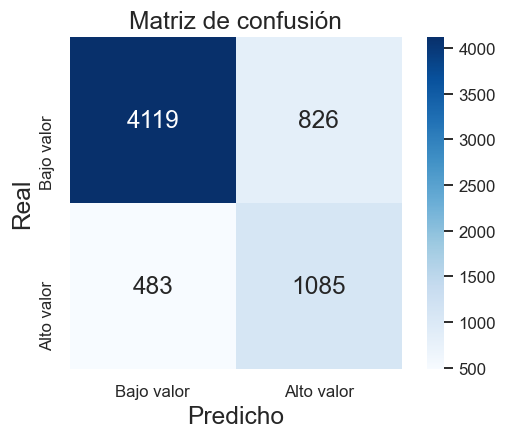

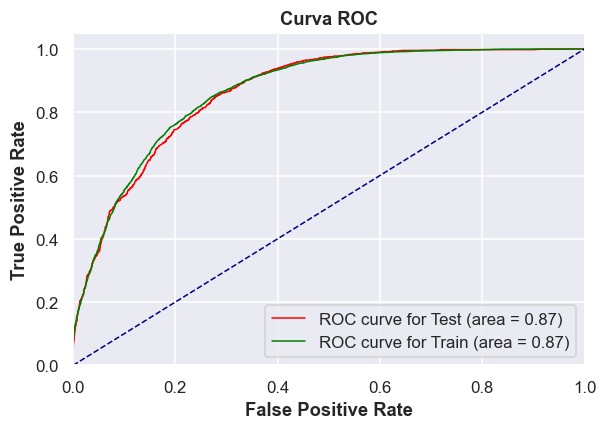

In [23]:
from sklearn.naive_bayes import MultinomialNB

X_df_d_n = obtener_features_discretas(X_df)
X_train, X_test, y_train, y_test = train_test_split(X_df_d_n, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1],
}

clf = MultinomialNB()
cv = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


In [24]:
proba_multi_train = clf.predict_proba(X_train)
proba_multi_test = clf.predict_proba(X_test)

## Segundo preprocesamiento: solo Scalers no negativos para toda MultinomialNB

In [25]:
def auc_scaler_no_negative(clf_r, XX_df, yy_df, params):
    scalers = [MinMaxScaler(), Normalizer()]
    for count, scaler in enumerate(scalers):
        print("---------------------------------------------------------------------")
        print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
        df_scaled = get_dataframe_scaled(XX_df, scaler)
        X_train, X_test, y_train, y_test = train_test_split(df_scaled, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        
        cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
        clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        print("Los mejores hiperpametros elegidos: ", clf.best_params_)
        '''
        print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
        graficar_matriz_confusion(y_test, y_pred)
        print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
        plot_roc_curves(clf, X_test, y_test, X_train, y_train)'''

  

In [26]:
X_df_d = obtener_features_discretas(X_df)
params =  {'alpha': [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1]}
auc_scaler_no_negative(MultinomialNB(), X_df_d, y_df, params)

---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.8563973478673572
AUC-ROC score sobre train:  0.8596401611223669
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de Normalizer()
 AUC-ROC score sobre test:  0.8544664137141206
AUC-ROC score sobre train:  0.8589477710646816
Los mejores hiperpametros elegidos:  {'alpha': 0.1}


## Tercer preprocesamiento: solo Polynomial

In [27]:
def auc_roc_polynomial(clf_r, XX_df, yy_df, grade, interaction_only, params):
        
    df_poly = get_dataframe_polynomial(XX_df, grade, interaction_only)
    X_train, X_test, y_train, y_test = train_test_split(df_poly, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        
    cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
    clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
    '''
    print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)
    print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
    graficar_matriz_confusion(y_test, y_pred)
    plot_roc_curves(clf, X_test, y_test, X_train, y_train)
    '''

* Grado 2, en True

In [28]:
X_df_d = obtener_features_discretas(X_df)
params =  {'alpha': [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1]}
auc_roc_polynomial(MultinomialNB(), X_df_d, y_df, 2, True, params)

 AUC-ROC score sobre test:  0.8538120860073048
AUC-ROC score sobre train:  0.8569614403067508


* Grado 2, en False

In [29]:
auc_roc_polynomial(MultinomialNB(), X_df_d, y_df, 2, False, params)

 AUC-ROC score sobre test:  0.8516733172035245
AUC-ROC score sobre train:  0.8549296394577688


Solo hasta grado 2, con grado 3 tarda mucho.


## Cuarto preprocesamiento: Scaler + Poly

Re ajustamos la funcion pues necesitamos aplicar 'escalados' que no nos den transformaciones negativas.

In [30]:
def auc_roc_scaler_polynomial_no_negative(clf_r, XX_df, yy_df, grade, interaction_only, params):
    scalers = [MinMaxScaler(), Normalizer()]

    for count, scaler in enumerate(scalers):
        df_scaled_poly = get_dataframe_scaler_polynomial(XX_df, scaler, grade, interaction_only)
        df_poly_scaled = get_dataframe_polynomial_scaler(XX_df, scaler, grade, interaction_only)
        dfs = {'scaled -> poly': df_scaled_poly, 'poly -> scaled': df_poly_scaled}
        for name, df_received in dfs.items(): 
            print("---------------------------------------------------------------------")
            print("Para dataset: ", name)
            print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
            X_train, X_test, y_train, y_test = train_test_split(df_received, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
                
            cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
            clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
                
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
            print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
            print("Los mejores hiperpametros elegidos: ", clf.best_params_)
            '''
            print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
            print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
            graficar_matriz_confusion(y_test, y_pred)
            plot_roc_curves(clf, X_test, y_test, X_train, y_train)
            '''



In [31]:
X_df_d = obtener_features_discretas(X_df)
params =  {'alpha': [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1]}
auc_roc_scaler_polynomial_no_negative(MultinomialNB(), X_df_d, y_df, 2, True, params)

---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 1 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8643288546460041
AUC-ROC score sobre train:  0.8674363369349467
Los mejores hiperpametros elegidos:  {'alpha': 0.3}
---------------------------------------------------------------------
Para dataset:  poly -> scaled
Aplicando preprocesamiento # 1 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8644056560945915
AUC-ROC score sobre train:  0.8675163418846206
Los mejores hiperpametros elegidos:  {'alpha': 0.3}
---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 2 con scaler de Normalizer()
AUC-ROC score sobre test:  0.8559151302077960
AUC-ROC score sobre train:  0.8602528243472366
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
---------------------------------------------------------------------
Para dataset:  po

# CategorialNB

Fitting 20 folds for each of 8 candidates, totalling 160 fits
AUC-ROC score sobre test:  0.8602924903530673
AUC-ROC score sobre train:  0.8630706398682936
Accuracy sobre test:  0.7813603562106556
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
              precision    recall  f1-score   support

  Bajo valor       0.79      0.91      0.85      4307
  Alto valor       0.75      0.53      0.62      2206

    accuracy                           0.78      6513
   macro avg       0.77      0.72      0.73      6513
weighted avg       0.78      0.78      0.77      6513



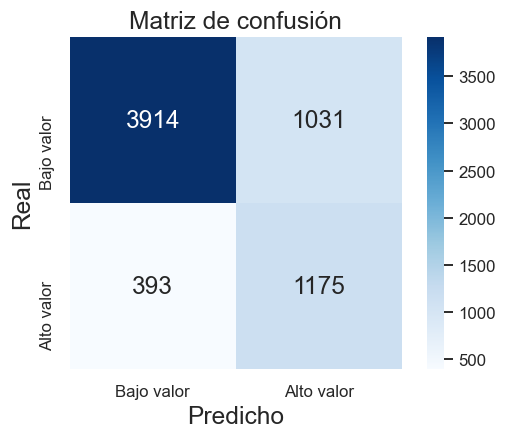

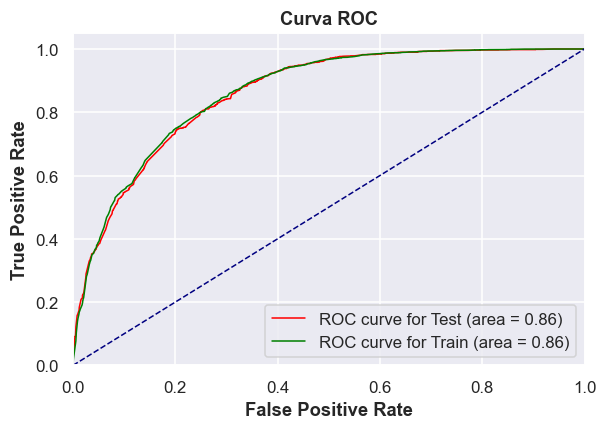

In [32]:
from sklearn.naive_bayes import CategoricalNB
X_df_cat = conversion_numerica(X_df[['categoria_de_trabajo', 'educacion_alcanzada', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']])

X_train, X_test, y_train, y_test = train_test_split(X_df_cat, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1],
}

clf = CategoricalNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


In [33]:
proba_catego_train = clf.predict_proba(X_train)
proba_catego_test = clf.predict_proba(X_test)

# Aplicando ensamble Gaussiano

Teniendo en cuenta lo visto en la clase práctica de la materia:

*en sklearn no tiene la funcionalidad de trabajar al mismo tiempo con variables categoricas y variables continuas. Se podria hacer un ensamble agarramos las probabilidades de GaussianNB, MultinomialNB y CategoricalNB y le metemos un gaussianNB al final juntando lo que devuelven los anteriores.*


Nos guiaremos ademas en la idea de utiliza las funciones de np.hstack tal como lo mencionado en la siguiente fuente:

https://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea

In [34]:
X_train_assemble = np.hstack((proba_gauss_train, proba_multi_train, proba_catego_train))
X_test_assemble = np.hstack((proba_gauss_test, proba_multi_test, proba_catego_test))

Podriamos intentar unir este *X_train* y *X_test* de la sigueinte forma: 

X_df_new = pd.DataFrame(np.vstack((X_train_assemble, X_test_assemble)))

Pero no seria lo correcto por que estamos asumiendo que la division realizada por **train_test_split** haya sido consecutiva.

In [35]:
X_train_assemble.shape

(26048, 6)

In [36]:
X_test_assemble.shape

(6513, 6)

Es decir, asumiriamos que agarró los 26048 elementos primero, y luego 6513 siguientes: eso no realiza *train_test_split* pues, la misma lo dividide teniendo en cuenta un factor random (lo cual al indicar el random_state=10 mantenemos siempre el mismo split) y ademas tiene en cuenta la division con respecto a la proporcion de la clase (stratify) a predecir, tal como como vimos en el notebook de *tp_FIUFIP_parte1_extras.ipynb*.

Al aplicar ese *np.vstack* asumimos que esto no haya pasado y por consiguiente el modelo nos podria dar cualquier cosa.

Comprobemoslo:

Fitting 20 folds for each of 7 candidates, totalling 140 fits
AUC-ROC score sobre test:  0.4854550566434865
AUC-ROC score sobre train:  0.5075605140969979
Accuracy sobre test:  0.7592507293106096
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       1.00      0.76      0.86      6513
  Alto valor       0.00      0.00      0.00         0

    accuracy                           0.76      6513
   macro avg       0.50      0.38      0.43      6513
weighted avg       1.00      0.76      0.86      6513

C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill

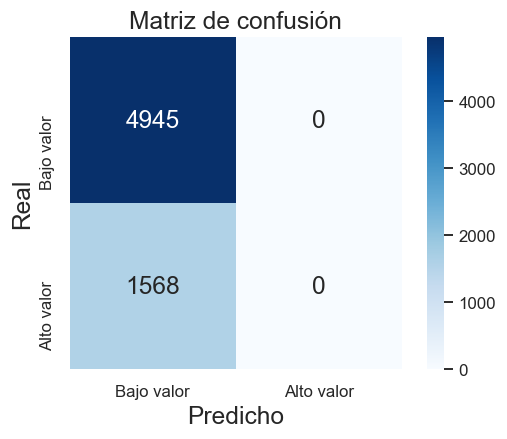

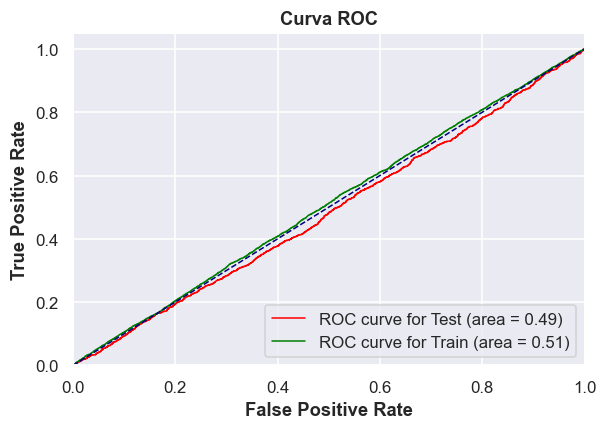

In [37]:
X_df_new = pd.DataFrame(np.vstack((X_test_assemble, X_train_assemble)))
X_train, X_test, y_train, y_test = train_test_split(X_df_new, y_df, test_size=0.20, random_state=0, stratify=y_df)

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Es decir, nos dió peor que un modelo RANDOM.

Para esto, entonces hagamos un split con 'train_test_split' tal como veniamos haciendo, manteniendo el mismo random_state pero solamente usaremos el *y_test* e *y_train* que nos dará el split, pues el *X_train* como *X_test* seran el del ensamble. Ademas respeteamos el split puesto que en cada modelo que usamos para el ensamble realizamos el mismo split.

Fitting 20 folds for each of 7 candidates, totalling 140 fits
AUC-ROC score sobre test:  0.8782285626586328
AUC-ROC score sobre train:  0.8791547182222771
Accuracy sobre test:  0.8122217104253032
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       0.84      0.90      0.87      4622
  Alto valor       0.71      0.59      0.65      1891

    accuracy                           0.81      6513
   macro avg       0.78      0.75      0.76      6513
weighted avg       0.81      0.81      0.81      6513



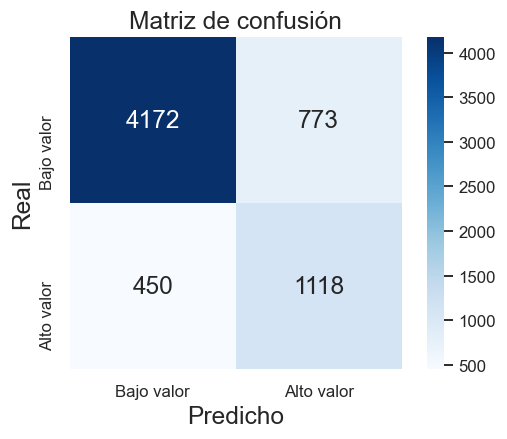

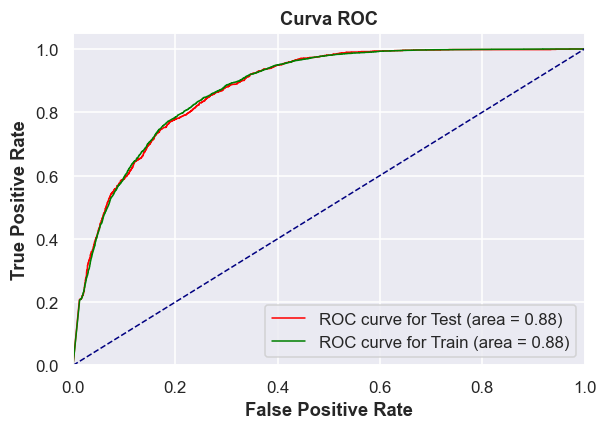

In [38]:
X_train_s, X_test_s, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train, X_test = X_train_assemble, X_test_assemble

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Lo cual se puede observar una mejora increible con un ensamble en comparacion a haber trabajo individualmente cada modelo.

## Primer preprocesings al ensamble: Scaler + Poly grado 2 en True

Tendremos que ajustar nuestra funcion a las consecuencias mencionadas de este ensamble con su split.

In [39]:
def auc_roc_scaler_polynomial_ensamble(clf_r, X_train_r, Y_test_r, X_df_r, yy_df, grade, interaction_only, params):
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), Normalizer()]

    for count, scaler in enumerate(scalers):
        df_scaled_poly_train = get_dataframe_scaler_polynomial(X_train_r, scaler, grade, interaction_only)
        df_scaled_poly_test = get_dataframe_scaler_polynomial(Y_test_r, scaler, grade, interaction_only)
        
        df_poly_scaled_train = get_dataframe_polynomial_scaler(X_train_r, scaler, grade, interaction_only)
        df_poly_scaled_test = get_dataframe_polynomial_scaler(Y_test_r, scaler, grade, interaction_only)

        dfs = {'scaled -> poly': [df_scaled_poly_train, df_scaled_poly_test], 'poly -> scaled': [df_poly_scaled_train, df_poly_scaled_test]}
        for name, received in dfs.items(): 

            print("---------------------------------------------------------------------")
            print("Para dataset: ", name)
            print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
            X_train_s, X_test_s, y_train, y_test = train_test_split(X_df_r, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
            X_train = received[0]
            X_test = received[1]
            
            cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
            clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
                
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
            print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
            print("Los mejores hiperpametros elegidos: ", clf.best_params_)
            '''
            print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
            print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
            graficar_matriz_confusion(y_test, y_pred)
            plot_roc_curves(clf, X_test, y_test, X_train, y_train)
            '''



* Grado 2, en True

In [40]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_scaler_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 2, True, params)

---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8644800716039702
AUC-ROC score sobre train:  0.8648194104607811
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------------------------
Para dataset:  poly -> scaled
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8790302382328057
AUC-ROC score sobre train:  0.8800651559278291
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-11}
---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8790711216235736
AUC-ROC score sobre train:  0.8800709520443906
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------

## Segundo preprocesings al ensamble: Scaler + Poly grado 2 en False

In [41]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_scaler_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 2, False, params)

---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8589295387012237
AUC-ROC score sobre train:  0.8607530638703427
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Para dataset:  poly -> scaled
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8789353165431997
AUC-ROC score sobre train:  0.8796173837547105
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8789747167825676
AUC-ROC score sobre train:  0.8796416444122797
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-08}
---------------------------------------------------

## Tercer preprocesings al ensamble: Scaler + Poly grado 3 en False

In [42]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_scaler_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 3, False, params)

---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8666744908276759
AUC-ROC score sobre train:  0.8681952452900004
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-09}
---------------------------------------------------------------------
Para dataset:  poly -> scaled
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8720220254431398
AUC-ROC score sobre train:  0.8730334709608716
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-09}
---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8716749035306741
AUC-ROC score sobre train:  0.8731823884313059
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------

## Cuarto preprocesings al ensamble: Scaler + Poly grado 3 en True

In [43]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_scaler_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 3, True, params)

---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8668241601493984
AUC-ROC score sobre train:  0.8672490554607338
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------------------------
Para dataset:  poly -> scaled
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
AUC-ROC score sobre test:  0.8827610088524793
AUC-ROC score sobre train:  0.8827075159871849
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Para dataset:  scaled -> poly
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
AUC-ROC score sobre test:  0.8828075024246301
AUC-ROC score sobre train:  0.8827109299723918
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------

## Quinto preprocessing: Solo PolynomialFeature

In [44]:
def auc_roc_polynomial_ensamble(clf_r, XX_train, XX_test, XX_df, yy_df, grade, interaction_only, params):
    X_train, X_test, y_train, y_test = train_test_split(XX_df, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        
    X_train = get_dataframe_polynomial(XX_train, grade, interaction_only)
    X_test = get_dataframe_polynomial(XX_test, grade, interaction_only)

    cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
    clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
    '''
    print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)
    print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
    graficar_matriz_confusion(y_test, y_pred)
    plot_roc_curves(clf, X_test, y_test, X_train, y_train)
    '''

* Grado 2, True

In [45]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 2, True, params)

 AUC-ROC score sobre test:  0.8790733141082520
AUC-ROC score sobre train:  0.8800717259347799


* Grado 2, False

In [46]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 2, False, params)

 AUC-ROC score sobre test:  0.8789873558118899
AUC-ROC score sobre train:  0.8796414872157943


* Grado 3, True

In [47]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 3, True, params)

 AUC-ROC score sobre test:  0.8828206573327005
AUC-ROC score sobre train:  0.8827163834812290


* Grado 3, False

In [48]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_roc_polynomial_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, 3, False, params)

 AUC-ROC score sobre test:  0.8715552841460145
AUC-ROC score sobre train:  0.8730307260683969


## Sexto preprocessing: solo Scalers

In [49]:
def auc_scaler_ensamble(clf_r, XX_train, XX_test, XX_df, yy_df, params):
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), Normalizer()]
    for count, scaler in enumerate(scalers):
        print("---------------------------------------------------------------------")
        print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
        X_train, X_test, y_train, y_test = train_test_split(XX_df, yy_df, test_size=0.20, random_state=10, stratify=y_df)        
        X_train = get_dataframe_scaled(XX_train, scaler)
        X_test = get_dataframe_scaled(XX_test, scaler)
        
        cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
        clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
        print("Los mejores hiperpametros elegidos: ", clf.best_params_)
        '''
        print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
        graficar_matriz_confusion(y_test, y_pred)
        print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
        plot_roc_curves(clf, X_test, y_test, X_train, y_train)'''

  

In [50]:
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
auc_scaler_ensamble(GaussianNB(), X_train, X_test, X_df, y_df, params)

---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
 AUC-ROC score sobre test:  0.8781364783021399
AUC-ROC score sobre train:  0.8790571516037164
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.8782285626586326
AUC-ROC score sobre train:  0.8791547182222771
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con scaler de RobustScaler()
 AUC-ROC score sobre test:  0.8782757655640618
AUC-ROC score sobre train:  0.8790518915674767
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-07}
---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con scaler de PowerTransformer()
 AUC-R